<a href="https://colab.research.google.com/github/DanielKorenDataScience/ClassificationProject/blob/main/Classification_Shufersal_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification Project - PRESENTATION

for Shufersal on-line orders, for replacing of missing products, will predict the replacement success!

In [46]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display
p = print
d = display

from sklearn.preprocessing import LabelEncoder

# Get Data

In [2]:
id = 'no_diff'
prefix = 'Shufersal'

DIFF = False
RATIO = False
REL = False

REMOVE_ING = False
SPLIT_DATE = False
SPLIT_DATE2 = False
ONLY_PRICE = False

SWEETS = True
CANS = False
DETERGENTS = False

In [44]:
def get_data(fname, partial=True):
  data_url = 'https://raw.githubusercontent.com/DanielKorenDataScience/ClassificationProject/main/' + fname
  p(fname)

  if partial:
    # Eliminating unwanted columns - mostly descriptive columns
    df = pd.read_csv(data_url, usecols=[i for i in range(82) if not i in[0,8,10,12,14,16,18,20,24,26,27,48,50,52,54,56,58,62,64,65]])
  else:
    df = pd.read_csv(data_url)
  return df

## Sweets or Cans or Detergents

In [4]:
if SWEETS:
  df = get_data('Sweets.csv')
elif CANS:
  df = get_data('Cans.csv')
else:  
  df = get_data('Detergents.csv')
df.head(1)

Sweets.csv


,HouseHoldID,LocationCityName,QuarterNumber,MonthNumber,WeekNumber,DayNumberInWeek,PeriodHoliday,DepartmentCode,CategoryCode,GroupCode,SubGroupCode,CompoundID,ParentProductNumber,BrandIndDesc,BrandName,VendorNumber,UnitOfMeasure,Price,Quantity,cntPrdAll,NetSaleAmountAll,NetSaleNoVatPrdLast3Months,QuantSale,cntMonths,DiscountPerUnit,isPromo,Energy,Pachmema,Natran,Helbon,Shuman,ShumanRavuy,ShumanTrans,Colastrol,SivimTzunatim,CafiotSucar,DepartmentCodeSubs,CategoryCodeSubs,GroupCodeSubs,SubGroupCodeSubs,CompoundIDSubs,ProductNumberSubs,BrandIndDescSuss,BrandNameSubs,VendorNumberSubs,UnitOfMeasureSubs,PriceSubs,NetSaleNoVatPrdSubs,QuantSaleSubs,cntMonthsSubs,DiscountPerUnitSubs,EnergySubs,PachmemaSubs,NatranSubs,HelbonSubs,ShumanSubs,ShumanRavuySubs,ShumanTransSubs,ColastrolSubs,SivimTzunatimSubs,CafiotSucarSusb,CorrelateItemStatusCode
0,1,ראשון לציון,202101,202102,202108,1,NotHoliday,10,6,700,3,-8000500249352,8000500249352,קינדר,לא מותג פרטי,914547,0.205,18.9,4,22,800.63,57747.16,0.8,16,NaN,noPromo,568.0,49.5,107.0,8.6,37.8,17.3,0.5,15.0,NaN,NaN,10,6,700,6,-8000500217740,8000500217740,קינדר,לא מותג פרטי,914547,0.086,9.9,46128.25,0.8,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# EDA

In [39]:
import seaborn as sns
try:
  from bidi import algorithm as bidialg
except:
  !pip install python-bidi
  from bidi import algorithm as bidialg

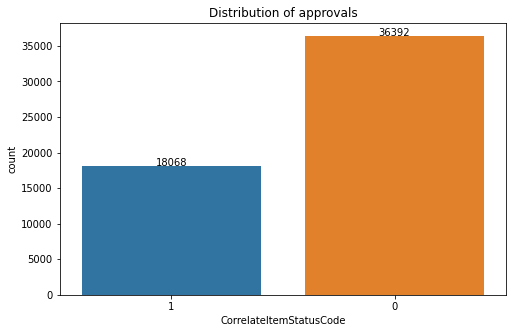

In [48]:
plt.figure(figsize=(8,5))
#ax=sns.histplot(df.CorrelateItemStatusCode.astype('int'), kde=False)
ax=sns.countplot(x=df.CorrelateItemStatusCode)
ax.set(title='Distribution of approvals')
# label each bar in histogram
for pa in ax.patches:
    height = pa.get_height() # get the height of each bar
    # adding text to each bar
    ax.text(x = pa.get_x()+(pa.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
    y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
    s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
    ha = 'center') # sets horizontal alignment (ha) to center
plt.xticks(df.CorrelateItemStatusCode.astype('int').unique())
plt.show()

In [49]:
df_cp = df.copy()
df_origin = get_data('Sweets.csv', partial=False)

Sweets.csv


In [19]:
df_cp['Refused'] = np.where(df_cp.CorrelateItemStatusCode==0, 1, 0)
df_cp = df_cp.rename(columns={'CorrelateItemStatusCode': 'Accepted'})

In [20]:
df_plot = df_cp.groupby(['WeekNumber'])[['Accepted','Refused']].sum().reset_index()

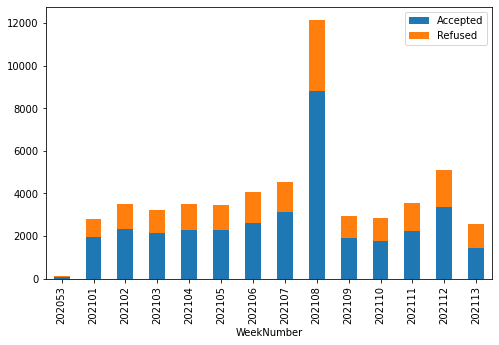

In [27]:
df_plot.set_index('WeekNumber').plot(kind='bar', stacked=True, figsize=(8,5))
plt.show()

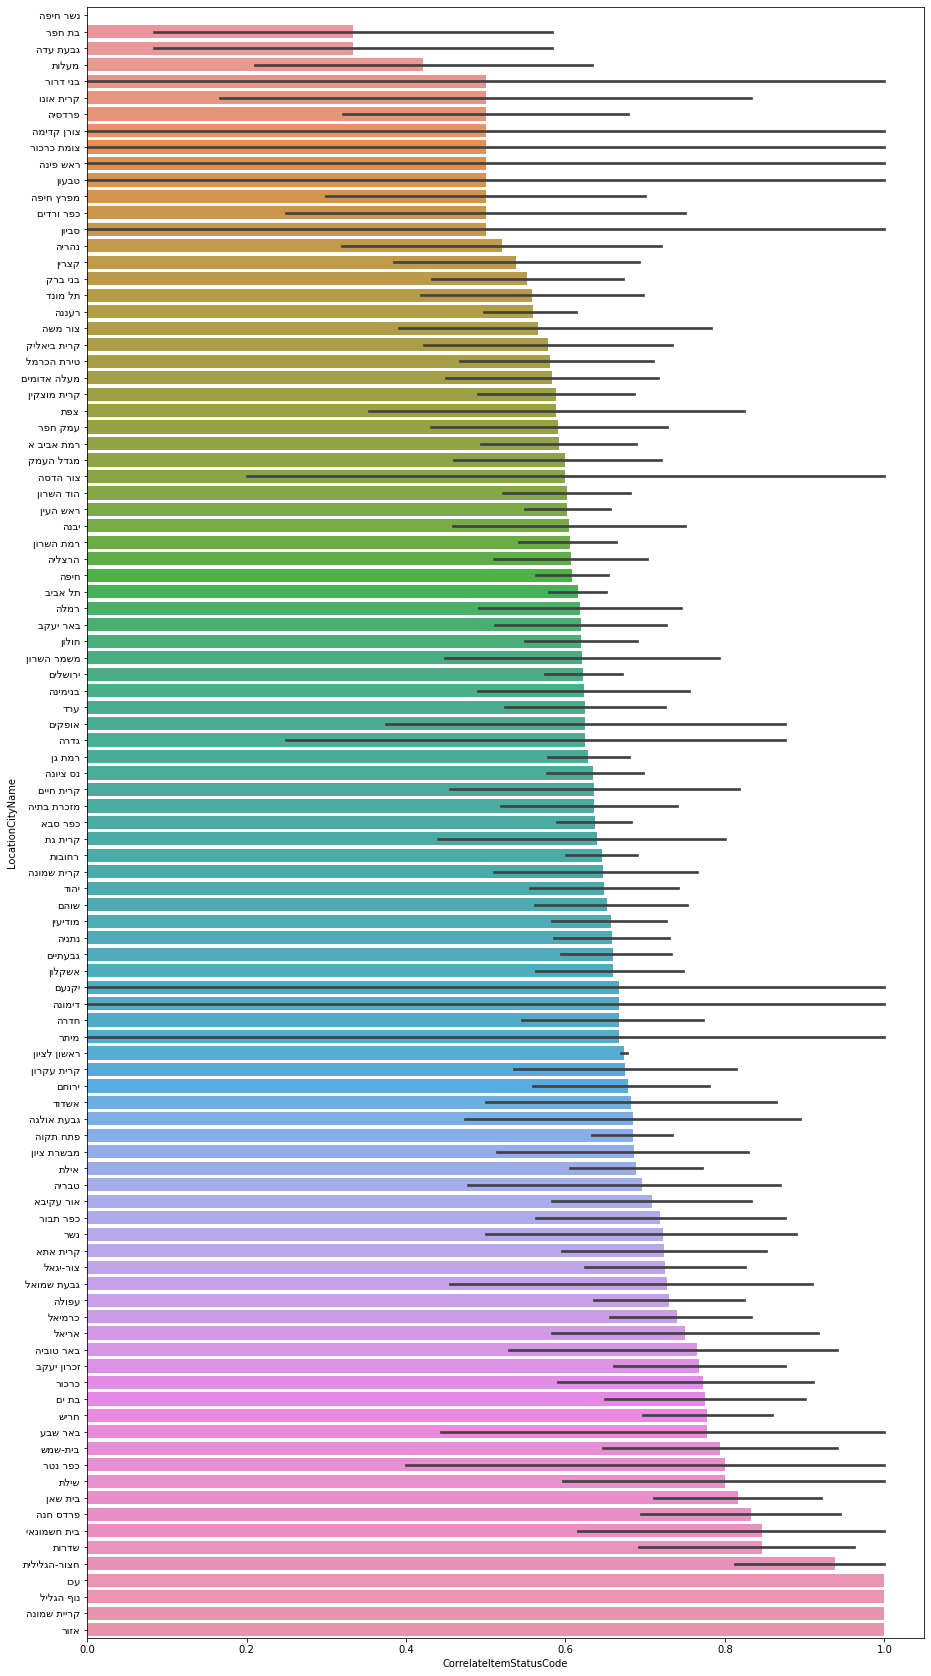

In [42]:
plt.figure(figsize=(15,30)) 
df_city = df_origin.groupby('LocationCityName')['CorrelateItemStatusCode'].mean().reset_index().sort_values('CorrelateItemStatusCode')
sns.barplot( y=df_origin.LocationCityName.apply( bidialg.get_display ), x=df_origin['CorrelateItemStatusCode'], order=df_city.LocationCityName.apply( bidialg.get_display ))
plt.show()

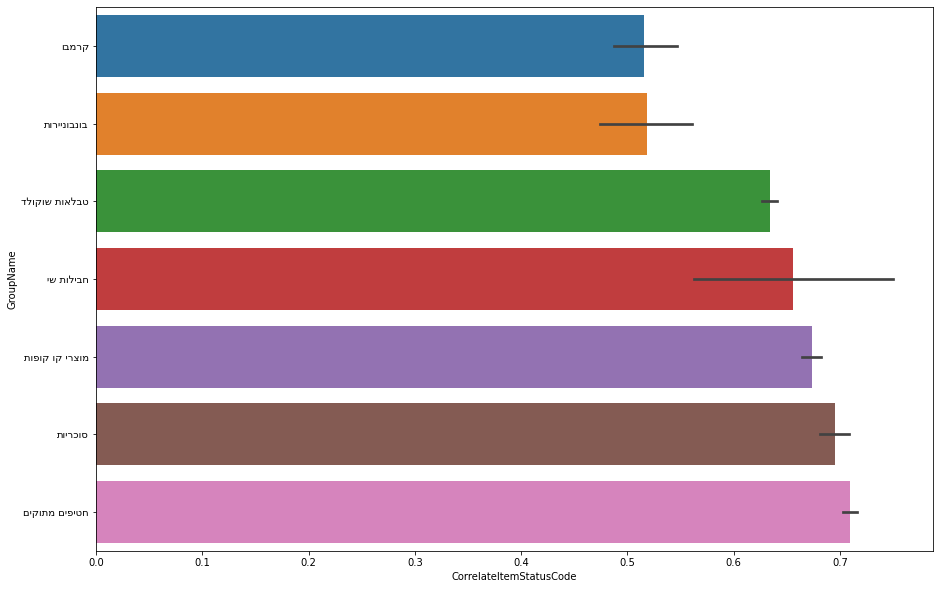

In [51]:
plt.figure(figsize=(15,10)) 
df_group = df_origin.groupby('GroupName')['CorrelateItemStatusCode'].mean().reset_index().sort_values('CorrelateItemStatusCode')
sns.barplot( y=df_origin.GroupName.apply( bidialg.get_display ), x=df_origin['CorrelateItemStatusCode'], order=df_group.GroupName.apply( bidialg.get_display ))
plt.show()

## Acceptance of Subs from different group

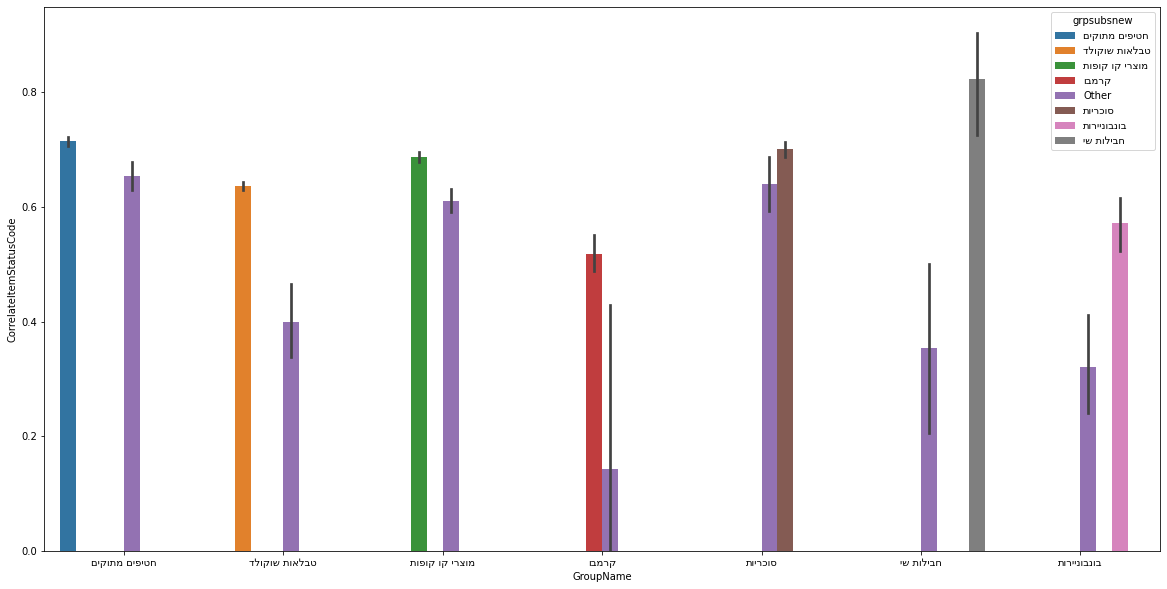

In [52]:
plt.figure(figsize=(20,10))
df_groupmatrix = df_origin[['GroupName', 'GroupNameSubs','CorrelateItemStatusCode']].copy()
df_groupmatrix['grpsubsnew'] = np.where(df_groupmatrix.GroupNameSubs==df_groupmatrix.GroupName,df_groupmatrix.GroupNameSubs,'Other')
sns.barplot(x=df_groupmatrix.GroupName.apply( bidialg.get_display ), y=df_groupmatrix.CorrelateItemStatusCode, hue=df_groupmatrix.grpsubsnew.apply( bidialg.get_display ))
plt.show()

## Correlation - Price is negative, isPromo is positive

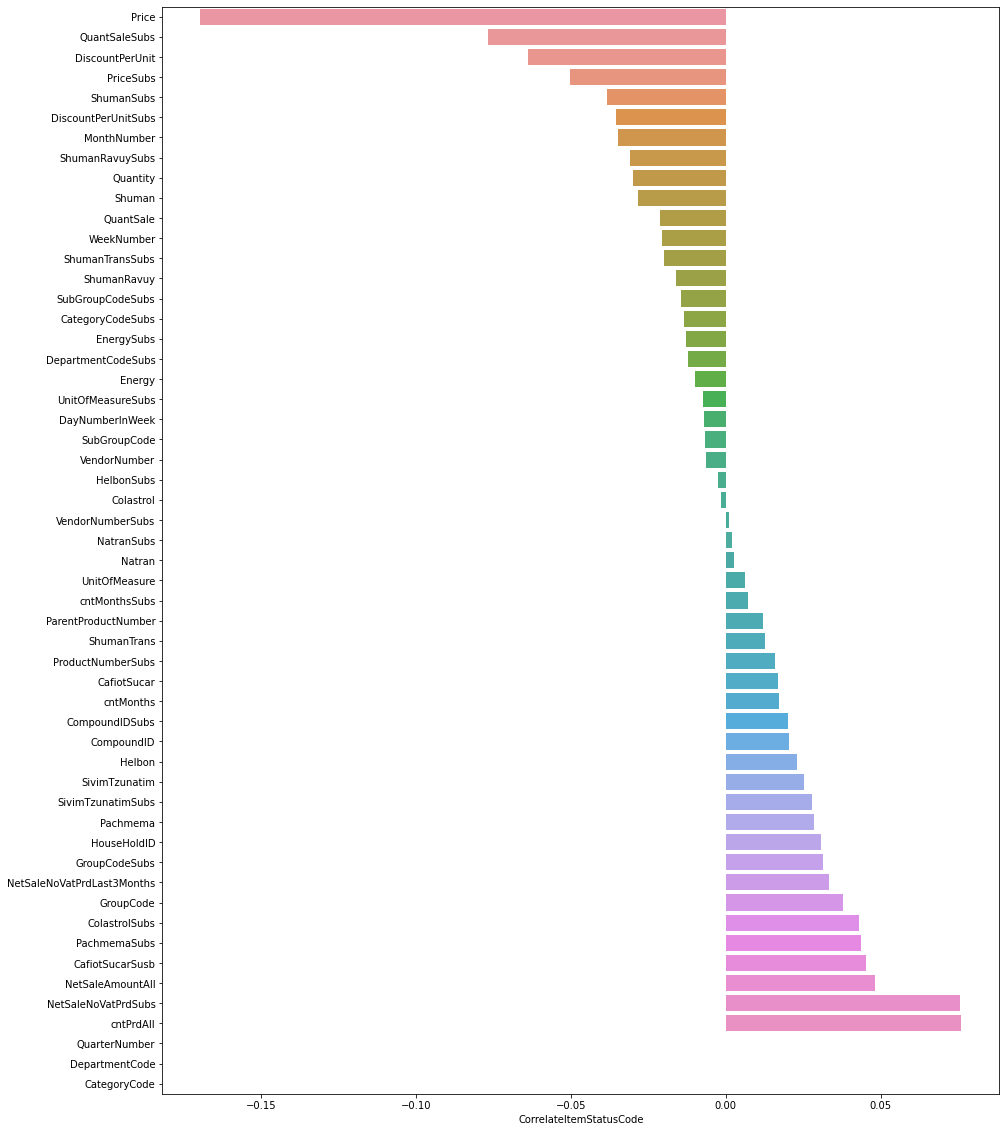

In [53]:
plt.figure(figsize=(15,20)) 
df_cor = df.corr()['CorrelateItemStatusCode'][:]
df_cor_ = pd.DataFrame(df_cor).sort_values('CorrelateItemStatusCode')
df_cor_ = df_cor_[df_cor_.index != 'CorrelateItemStatusCode']
sns.barplot( y=df_cor_.index, x=df_cor_['CorrelateItemStatusCode'])
plt.show()

# Various Data Sets - Functions

## Calc diff vector

In [ ]:
def prepare_diff(df):
  id = ''
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar', 'QuantSale', 'cntMonths', 'DiscountPerUnit']:
    df[col + 'Diff'] = df[col] - df[col + 'Subs']

  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
    df[col + 'Diff'] = (df[col + 'Diff'] != 0)    # tested both ==0 and !=0 (the result is 1 for one and 0 for the other - no change in the model results)
    df[col + 'Diff'] = enc.fit_transform(df[col + 'Diff'])

  return df

## Calc Ratio vector - no change in results

note: changes affects only columns that are not categorical because those we change to 0/1 in the 2nd step below

In [ ]:
def prepare_ratio(df):
  id = 'ratio'
  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar', 'QuantSale', 'cntMonths', 'DiscountPerUnit']:
    df[col + 'Ratio'] = df.apply(lambda row: 999 if row[col + 'Subs'] == 0 else row[col] / row[col + 'Subs'], axis=1)

  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
    df[col + 'Ratio'] = (df[col + 'Ratio'] != 1.0)
    df[col + 'Ratio'] = enc.fit_transform(df[col + 'Ratio'])

  return df

## Calc Relative Diff - no change in results

note: changes affects only columns that are not categorical because those we change to 0/1 in the 2nd step below

In [ ]:
def prepare_rel(df):
  id = 'rel_diff'

  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'BrandIndDesc',
       'VendorNumber', 'UnitOfMeasure', 'Price', 'NetSaleNoVatPrdLast3Months', 'Energy', 'Pachmema',
       'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar', 'QuantSale', 'cntMonths', 'DiscountPerUnit']:
    df[col + 'RelDiff'] = df.apply(lambda row: 1 if row[col] == 0 else (row[col] - row[col + 'Subs']) / row[col], axis=1)

  for col in ['DepartmentCode', 'CategoryCode', 'GroupCode', #'SubGroupCode',
       'CompoundID', 'ParentProductNumber', 'VendorNumber', 'BrandIndDesc']:
    df[col + 'RelDiff'] = (df[col + 'RelDiff'] != 0.0)
    df[col + 'RelDiff'] = enc.fit_transform(df[col + 'RelDiff'])

  return df    

## Models - remove ingredients - no change in results

In [ ]:
def do_remove_ing(df):
  global X_train, X_test, y_train, y_test

  id = 'remove_ingredients'

  try:
    del X_train, X_test, y_train, y_test
  except:
    pass
  
  cols = ['CorrelateItemStatusCode']
  for col in ['Energy', 'Pachmema', 'Natran', 'Helbon', 'Shuman', 'ShumanRavuy', 'ShumanTrans', 'Colastrol',
       'SivimTzunatim', 'CafiotSucar']:
      cols.append(col)
      cols.append(col + 'Subs')
      cols.append(col + 'Diff')

  X = df.drop(cols, axis=1)
  y = df.CorrelateItemStatusCode.astype(int)

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
#  p(df.shape)
#  p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## Models - split based on date - major change (precision went down from 84% to 78%)

In [ ]:
def do_split_date(df):
  global X_train, X_test, y_train, y_test
 
  id = 'split_based_on_date'

  mask = df.WeekNumber > 202108
  try:
    del X_train, X_test, y_train, y_test
  except:
    pass

  df_train = df[~mask]
  X_train = df_train.drop('CorrelateItemStatusCode', axis=1)
  y_train = df_train.CorrelateItemStatusCode.astype(int)

  df_test = df[mask]
  X_test = df_test.drop('CorrelateItemStatusCode', axis=1)
  y_test = df_test.CorrelateItemStatusCode.astype(int)

  #Variant - remove the date related columns - must be run after the SPLIT_DATE run because it prepares the X_train
  if SPLIT_DATE2:
    id = 'split_based_on_date_without_date_features_and_order_info'

    cols = ['QuarterNumber', 'MonthNumber', 'WeekNumber', 'DayNumberInWeek', 
            'PeriodHoliday_0', 'PeriodHoliday_1',
            'Quantity', 'cntPrdAll', 'NetSaleAmountAll']
    X_train = X_train.drop(cols, axis=1)
    X_test = X_test.drop(cols, axis=1)
#    p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#  p(df.shape)
#  p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

## Models - remove all features execpt of prices

In [ ]:
def do_only_price(df):
  global X_train, X_test, y_train, y_test

  id = 'only_prices'
  try:
    del X_train, X_test, y_train, y_test
  except:
    pass
  
  X = df[['Price', 'PriceSubs', 'PriceDiff']]
  y = df.CorrelateItemStatusCode.astype(int)

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
#  p(df.shape)
#  p(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Prepare Data

In [ ]:
def prepare(df):
  ## Fix Typo mistake
  df.rename(columns={'OrderNumbert': 'OrderNumber','BrandIndDescSuss': 'BrandIndDescSubs', 'ProductNumberSubs': 'ParentProductNumberSubs', \
                    'NetSaleNoVatPrdSubs': 'NetSaleNoVatPrdLast3MonthsSubs', 'CafiotSucarSusb': 'CafiotSucarSubs'}, inplace=True)
  
  ##Eliminating nulls
  df.fillna({'QuantSale': 1, 'QuantSaleSubs': 1}, inplace=True)
  df.fillna(0, inplace=True)

  ## Encoding categories
  enc = LabelEncoder()
  enc.fit(['PromoSusbDiffPromo', 'PromoSusbSamePromo', 'noPromo'])
  df.isPromo = enc.transform(df.isPromo)

  df['LocationCityName'] = df.LocationCityName.astype('str')
  df['BrandIndDesc'] = df.BrandIndDesc.astype('str')
  df['BrandIndDescSubs'] = df.BrandIndDescSubs.astype('str')
  for col in ['LocationCityName', 'PeriodHoliday', 'BrandIndDesc', 'BrandName', 'BrandIndDescSubs', 'BrandNameSubs']:
    df[col] = enc.fit_transform(df[col])

  ## Combine 'GroupCode' and 'SubGroupCode' into one column
  df.GroupCode = df.GroupCode * 10 + df.SubGroupCode
  df.GroupCodeSubs = df.GroupCodeSubs * 10 + df.SubGroupCodeSubs

  ## Use Dummies
  ## Minimal improvement - FalseNegative (0,0) improved from 1338 to 1328
  df = pd.get_dummies(df, columns=['isPromo', 'PeriodHoliday'])

  if DIFF:
    df = prepare_diff(df)
  elif RATIO:
    df = prepare_ratio(df)
  elif REL:
    df = prepare_rel(df)
  return df    

df = prepare(df)    

# Models


## Models - process_model code

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import math

pd.set_option("precision", 2)
df_result = pd.DataFrame()

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X = df.drop('CorrelateItemStatusCode', axis=1)
y = df.CorrelateItemStatusCode.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

if REMOVE_ING:
  do_remove_ing(df)
elif SPLIT_DATE or SPLIT_DATE2:
  do_split_date(df)
elif ONLY_PRICE:  
  do_only_price(df)

In [ ]:
def report(clf, X, y, note, test, data_type='Test'):
  global df_result
  name = type(clf).__name__ + ': ' + data_type
  acc = accuracy_score(y_true=y, y_pred=clf.predict(X))
  index = [(name, clf.classes_[0]), (name, clf.classes_[1])]
  cm = pd.DataFrame(confusion_matrix(y_true=y, y_pred=clf.predict(X)),
                    index=clf.classes_,
                    columns=clf.classes_)
  cm.reset_index(drop=True, inplace=True)
  rep = classification_report(y_true=y, y_pred=clf.predict(X), zero_division=1, output_dict=True)
  rep =  pd.DataFrame(rep)
  rep = rep.T
  rep['accuracy'] = acc
  rep.support = rep.support.astype(int)
  cols = list(rep.columns[:3]) + ['accuracy', 'support']
  rep = rep[cols]
  rep['precision_avg'] = rep.precision['macro avg']
  rep['recall_avg'] = rep.recall['macro avg']
  rep['f1-score_avg'] = rep['f1-score']['macro avg']
  rep.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0, inplace=True)
  rep.reset_index(drop=True, inplace=True)
  df = cm.join(rep)
  df['name'] = name
  df['note'] = note
  df.loc[1, 'note'] = ''
  if test:  # do not add to database
    d(df)
  else:    
    df.reset_index(inplace=True)
    df_result.reset_index(inplace=True)
    df_result = df_result.append(df, ignore_index=True)
    df_result.set_index(['name', 'index'], inplace=True)
  return df_result

In [ ]:
#ROC and AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_and_auc(model,X_test,y_test):
    ns_probs = [0 for _ in range(len(y_test))]
#    lr_probs = clf_voting.predict_proba(X_test)[:,1]
    lr_probs = model.predict_proba(X_test)[:,1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('\nNo Skill: ROC AUC=%.3f' % (ns_auc))
    print('model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    fig = plt.figure(figsize=(5,5))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(type(model).__name__ )
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [ ]:
def showFeatureImportance(model, X, threshold):
  if type(model).__name__ == 'LogisticRegression':  # no features importance data
    w0 = model.intercept_[0]
    w = model.coef_[0]
    fx_imp = pd.Series(w, index=X.columns)
  else:
    fx_imp = pd.Series(model.feature_importances_, index=X.columns)
  fx_imp /= fx_imp.sum()
  fx_imp = fx_imp.sort_values()
  fx_imp = fx_imp[fx_imp > threshold]
  fig = plt.figure(figsize=(5,5))
  plt.xlim(0, 1)
  fx_imp.plot(kind='barh', title=type(model).__name__ )

In [ ]:
def process_model(model, X, y, X_test, y_test, plot=False, threshold=0, note='', test=False):
  p('running: ', type(model).__name__, X.shape)
  model.fit(X, y)
  report(model, X, y, note, test, 'Train')
  report(model, X_test, y_test, note, test)
  if plot:
    showFeatureImportance(model, X, threshold)
    get_roc_and_auc(model,X_test,y_test)    
  return df_result 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


## Models - Run process_model

running:  RandomForestClassifier (38122, 64)

No Skill: ROC AUC=0.500
model: ROC AUC=0.919


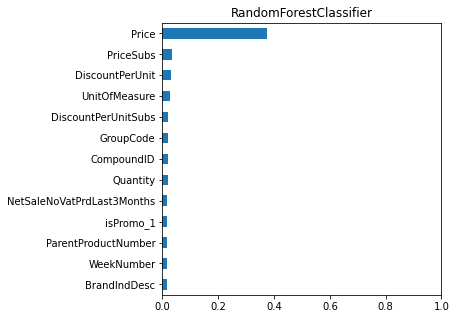

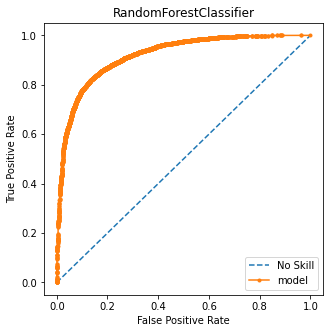

0  ...                                               note
name                          index          ...                                                   
RandomForestClassifier: Train 0      9087.0  ...  n_estimators=200, criterion='entropy', max_dep...
                              1      1319.0  ...                                                   
RandomForestClassifier: Test  0      3674.0  ...  n_estimators=200, criterion='entropy', max_dep...
                              1       760.0  ...                                                   

[4 rows x 11 columns]

no_diff


In [ ]:
ONLY_RF = True
df_result = pd.DataFrame()

if not ONLY_RF:
  process_model(LogisticRegression(max_iter=1000), X_train, y_train, X_test, y_test, note='max_iter=1000', threshold=0.0000005)  # did not fit, return accuracy=0, so we increased max_iter from default 100
  process_model(LogisticRegression(C=100, max_iter=1000, fit_intercept=False, warm_start=True), X_train, y_train, X_test, y_test, note='max_iter=1000, C=100, fit_intercept=False, warm_start=True', threshold=0.0000005, plot=False)

  clf_GB = GradientBoostingClassifier(n_estimators=100)
  process_model(clf_GB, X_train, y_train, X_test, y_test, plot=False, threshold=0.015, note='n_estimators=100')
  clf_GB = GradientBoostingClassifier(ccp_alpha=0.0001, n_estimators=200, random_state=1234)
  process_model(clf_GB, X_train, y_train, X_test, y_test, plot=False, threshold=0.015, note='ccp_alpha=0.0001, n_estimators=200, random_state=1234')

  clf_AB = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.01)
  process_model(clf_AB, X_train, y_train, X_test, y_test)

  process_model(KNeighborsClassifier(n_neighbors=39), X_train, y_train, X_test, y_test)

  if not REL: #ERROR: Classification metrics can't handle a mix of binary and continuous targets
    process_model(VotingClassifier(estimators=[('RF', clf_RF), ('GB', clf_GB), ('AB', clf_AB)], voting='soft'), X_train, y_train, X_test, y_test, note="('RF', clf_RF), ('GB', clf_GB), ('AB', clf_AB')")

clf_RF = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=None, min_samples_split=20, ccp_alpha=0.0003, random_state=73)
process_model(clf_RF, X_train, y_train, X_test, y_test, plot=True, threshold=0.015, note="n_estimators=200, criterion='entropy', max_depth=None, min_samples_split=20, ccp_alpha=0.0003, random_state=1234")

d(df_result)

fname = prefix + f'_result_{id}.csv'
df_result.to_csv(fname, index = True)
p(id)

## Models - compare results

1. Diff
2. Diff with remove ingredients columns
3. Diff with split based on date
3. Diff with split based on date (without date features and order info) 
4. Ratio
5. RelDiff - relative difference
6. OnlyPrices - Diff with only 3 features( Price, PriceSubs, PriceDiff)
8. No Diff (no comparison between master and subs)

In [ ]:
def get_raw(fname, subdir=''):
  data_url = 'https://raw.githubusercontent.com/DanielKorenDataScience/ClassificationProject/main/' + subdir + fname
  return pd.read_csv(data_url)

In [ ]:
def read_results(id='', disp=True, full=False):
  fname = prefix + f'_result_{id}.csv'
  p(fname)
  try:
    df = pd.read_csv(fname)
  except:
    try:
      df = get_raw(fname, 'Results/')
#      df = pd.read_csv(fname)
    except:
      p('No data')
      return
  df.set_index(['name', 'index'], inplace=True)
  if not full:
    df = df.loc[['RandomForestClassifier: Train', 'RandomForestClassifier: Test']]#.copy()
  if disp:
    pd.set_option("max_column", 120)
    d(df)
  return df

In [ ]:
p(id)
read_results()
read_results('remove_ingredients')
read_results('split_based_on_date')
read_results('split_based_on_date_without_date_features_and_order_info')
read_results('ratio')
read_results('rel_diff')
read_results('only_prices')
read_results('no_diff')
p()

no_diff
Shufersal_result_.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9267.0   3382.0       0.86    0.73   
                              1      1546.0  23927.0       0.88    0.94   
RandomForestClassifier: Test  0      3804.0   1615.0       0.81    0.70   
                              1       879.0  10040.0       0.86    0.92   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.87  12649.0   
                              1          0.91      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.87        0.84          0.85   
                              1               0.87        0.84          0.85   
RandomForestClassifier: Test  0               0.84        0.81          0.82   
                              1               0.84        0.81          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_remove_ingredients.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9116.0   3533.0       0.86    0.72   
                              1      1512.0  23961.0       0.87    0.94   
RandomForestClassifier: Test  0      3767.0   1652.0       0.82    0.70   
                              1       828.0  10091.0       0.86    0.92   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.78      0.87  12649.0   
                              1          0.90      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.86        0.83          0.84   
                              1               0.86        0.83          0.84   
RandomForestClassifier: Test  0               0.84        0.81          0.82   
                              1               0.84        0.81          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_split_based_on_date.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      8644.0   3102.0       0.86    0.74   
                              1      1419.0  24252.0       0.89    0.94   
RandomForestClassifier: Test  0      3699.0   2623.0       0.78    0.59   
                              1      1072.0   9649.0       0.79    0.90   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.88  11746.0   
                              1          0.91      0.88  25671.0   
RandomForestClassifier: Test  0          0.67      0.78   6322.0   
                              1          0.84      0.78  10721.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.87        0.84          0.85   
                              1               0.87        0.84          0.85   
RandomForestClassifier: Test  0               0.78        0.74          0.75   
                              1               0.78        0.74          0.75   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_split_based_on_date_without_date_features_and_order_info.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      8386.0   3360.0       0.84    0.71   
                              1      1569.0  24102.0       0.88    0.94   
RandomForestClassifier: Test  0      3685.0   2637.0       0.78    0.58   
                              1      1042.0   9679.0       0.79    0.90   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.77      0.87  11746.0   
                              1          0.91      0.87  25671.0   
RandomForestClassifier: Test  0          0.67      0.78   6322.0   
                              1          0.84      0.78  10721.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.86        0.83          0.84   
                              1               0.86        0.83          0.84   
RandomForestClassifier: Test  0               0.78        0.74          0.75   
                              1               0.78        0.74          0.75   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_ratio.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9227.0   3422.0       0.85    0.73   
                              1      1586.0  23887.0       0.87    0.94   
RandomForestClassifier: Test  0      3797.0   1622.0       0.81    0.70   
                              1       899.0  10020.0       0.86    0.92   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.87  12649.0   
                              1          0.91      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.86        0.83          0.85   
                              1               0.86        0.83          0.85   
RandomForestClassifier: Test  0               0.83        0.81          0.82   
                              1               0.83        0.81          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_rel_diff.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9280.0   3369.0       0.86    0.73   
                              1      1567.0  23906.0       0.88    0.94   
RandomForestClassifier: Test  0      3829.0   1590.0       0.81    0.71   
                              1       899.0  10020.0       0.86    0.92   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.87  12649.0   
                              1          0.91      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.87        0.84          0.85   
                              1               0.87        0.84          0.85   
RandomForestClassifier: Test  0               0.84        0.81          0.82   
                              1               0.84        0.81          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_only_prices.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      8819.0   3830.0       0.77    0.70   
                              1      2709.0  22764.0       0.86    0.89   
RandomForestClassifier: Test  0      3786.0   1633.0       0.75    0.70   
                              1      1234.0   9685.0       0.86    0.89   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.73      0.83  12649.0   
                              1          0.87      0.83  25473.0   
RandomForestClassifier: Test  0          0.73      0.82   5419.0   
                              1          0.87      0.82  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.81        0.80           0.8   
                              1               0.81        0.80           0.8   
RandomForestClassifier: Test  0               0.80        0.79           0.8   
                              1               0.80        0.79           0.8   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

Shufersal_result_no_diff.csv


0        1  precision  recall  \
name                          index                                       
RandomForestClassifier: Train 0      9087.0   3562.0       0.87    0.72   
                              1      1319.0  24154.0       0.87    0.95   
RandomForestClassifier: Test  0      3674.0   1745.0       0.83    0.68   
                              1       760.0  10159.0       0.85    0.93   

                                     f1-score  accuracy  support  \
name                          index                                
RandomForestClassifier: Train 0          0.79      0.87  12649.0   
                              1          0.91      0.87  25473.0   
RandomForestClassifier: Test  0          0.75      0.85   5419.0   
                              1          0.89      0.85  10919.0   

                                     precision_avg  recall_avg  f1-score_avg  \
name                          index                                            
RandomForestClassifier: Train 0               0.87        0.83          0.85   
                              1               0.87        0.83          0.85   
RandomForestClassifier: Test  0               0.84        0.80          0.82   
                              1               0.84        0.80          0.82   

                                                                                  note  
name                          index                                                     
RandomForestClassifier: Train 0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN  
RandomForestClassifier: Test  0      n_estimators=200, criterion='entropy', max_dep...  
                              1                                                    NaN

#Baseline Model

In [ ]:
def returnPrec(model,products):
            productCols=['ParentProductNumber','ParentProductNumberSubs']
            val=model[(model[productCols[0]]==products[0]) & (model[productCols[1]]==products[1])]['avgApproval']
            if val.empty ==False:
                #display(val)
                return val.iloc[0]
            #print(val)
            return -1

In [ ]:
class BaselineModel:
    def __init__(self, classes_):
        self.classes_ = classes_
    def fit(self,X_, y_):
        #catalogCols=['ParentProductNumber','CompoundID','SubGroupCodeNew','GroupCode']
        cols=['ParentProductNumber','ParentProductNumberSubs']
        group=pd.concat([X_[cols],y_],axis=1).apply(lambda x:x.astype(np.int64))\
            .groupby(cols)\
            .agg({'CorrelateItemStatusCode':[('avgApproval','mean'),('countRows','count')]}).reset_index()
        group.columns=group.columns.droplevel(0)
        group.columns.values[0]=cols[0]
        group.columns.values[1]=cols[1]
        group=group[group['countRows']>=5]
        display(group.head())
        display(len(group))
        self.model=group 
        return self
    
    def predict(self,X_): 
        #print(type(X_))
        y_predPrec = X_.apply(lambda x: returnPrec( model=self.model,products=[x['ParentProductNumber'],
                                                                                 x['ParentProductNumberSubs']]),axis=1)
        #display(y_predPrec)
        y_pred=np.where(y_predPrec>0.5,1,0)
        return y_pred
    def predict_proba(self,X_):
        y_predPrec = X_.apply(lambda x: returnPrec(model=self.model, products=[x['ParentProductNumber'],
                                                                                 x['ParentProductNumberSubs']]),axis=1)
        return y_predPrec

In [ ]:
baseline=BaselineModel(df.CorrelateItemStatusCode.unique())

In [ ]:
baseline.fit(X_train,y_train)

In [ ]:
y_pred=baseline.predict(X_test)

##Example baseline model

In [ ]:
y_train[(X_train['ParentProductNumber']==161631) & (X_train['ParentProductNumberSubs']==72909799)].sum()\
/len(y_train[(X_train['ParentProductNumber']==161631) & (X_train['ParentProductNumberSubs']==72909799)])

In [ ]:
baseline.predict_proba(X_test[(X_test['ParentProductNumber']==161631) & (X_test['ParentProductNumberSubs']==72909799)])

In [ ]:
print(len(y_pred[y_pred==0]))
print(len(y_pred[y_pred==1]))
print(len(y_pred[y_pred==-1]))

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
process_model(BaselineModel(df.CorrelateItemStatusCode.unique()))

# Grid Search for hyperparameters - on best model RandonForest

It run for few hours and then colab disconnected - it was to preform 5880 checks. From the partial results (because Verbose=4) I saw that n_estimators=500, min_samples_split=6, criterion='entropy' gives better results so we implemented them and we can see that indeed precision was improved from 84% to 85% 

In [ ]:
GS = False
if GS and False:
  clf_RF = RandomForestClassifier(n_estimators=64)
  clf_RF.fit(X_train, y_train)
  p(clf_RF.score(X_train, y_train))
  p(clf_RF.score(X_test, y_test))

In [ ]:
def run_GS(model, param_grid, n_jobs=-1, cv=5, verbose=4):
  if verbose > 3 and n_jobs == -1:
    p('Warning: when n_jobs=-1 no partial results are displayed')
    p('Change one of the parameters - Aborted')
    return
  clf_gs = GridSearchCV(model, param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
  clf_gs.fit(X_train, y_train)

  p('Results')
  clf_gs.estimator
  p(clf_gs.best_params_)
  p(clf_gs.best_estimator_)
  p('After')
  p(clf_gs.score(X_train, y_train))
  p(clf_gs.score(X_test, y_test))

In [ ]:
if GS and False:
  param_grid = { 
      'max_depth' : [None, 8, 15],
      'ccp_alpha': [0.0001, 0.0003, 0.0005],
      'n_estimators': [100, 200],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'max_leaf_nodes': [None, 20, 40],
      'min_samples_split': [2, 10, 20],
      'random_state': [73]
  }
  model = GradientBoostingClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

In [ ]:
if GS:
  param_grid = { 
#      'max_depth' : [None, 8, 15],
      'ccp_alpha': [0.0008, 0.001, 0.002],
      #'n_estimators': [100],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
#      'max_leaf_nodes': [None, 20, 40],
      'min_samples_split': [2],
      'random_state': [73]
  }
  model = GradientBoostingClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

Results
{'ccp_alpha': 0.0005, 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 73}
GradientBoostingClassifier(ccp_alpha=0.0005, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='deviance',
                           max_depth=None, max_features=None,
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           presort='deprecated', random_state=73, subsample=1.0,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

After

0.8204559424860357

0.764712785307751


In [ ]:
if GS:
  param_grid = { 
      'max_depth' : [None, 8, 15],
      'ccp_alpha': [0.0001, 0.0003, 0.0005],
      'n_estimators': [100, 200],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['gini', 'entropy'], 
      'max_leaf_nodes': [None, 20, 40],
      'min_samples_split': [2, 10, 20],
      'random_state': [73]
  }
  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

In [ ]:
if GS:
  param_grid = { 
      'max_depth' : [None, 4,5,6,7,8],
      'ccp_alpha': [0.01, 0.02, 0.03, 0.1],
  #    'n_estimators': [64, 200, 500],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['gini', 'entropy'], 
  #   'max_leaf_nodes': [None, 4, 10, 20],
      'min_samples_split': [20, 100, 500]#[2, 4, 6, 8, 10, 12, 14]
  }
  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

In [ ]:
if GS and False:
  param_grid = { 
      'max_depth' : [None, 4,8,10],
      'ccp_alpha': [0.005, 0.01, 0.015],
  #    'n_estimators': [64, 200, 500],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['entropy'], 
  #   'max_leaf_nodes': [None, 4, 10, 20],
      'min_samples_split': [10, 20, 30]
  }

  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

> output:

Fitting 5 folds for each of 144 candidates, totalling 720 fits

{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 20}

In [ ]:
if GS and False:
  param_grid = { 
      'max_depth' : [None, 4,8,10],
      'ccp_alpha': [0.005, 0.01, 0.015],
  #    'n_estimators': [64, 200, 500],
  #    'max_features': ['auto', 'sqrt', 'log2', 1.0, 0.75, 0.5, 0.25],
      'criterion' :['entropy'], 
  #   'max_leaf_nodes': [None, 4, 10, 20],
      'min_samples_split': [10, 20, 30]
  }

  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

> Output

Fitting 5 folds for each of 36 candidates, totalling 180 fits

{'ccp_alpha': 0.005, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 20}

Train: 0.7725460364094224

Test: 0.7751866813563472

In [ ]:
if GS and False:
  param_grid = { 
      'max_depth' : [None],
      'ccp_alpha': [0.001, 0.003, 0.005],
      'criterion' :['entropy'], 
      'min_samples_split': [20],
      'n_estimators': [64, 200, 500],
  }
  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

> Output

Fitting 5 folds for each of 9 candidates, totalling 45 fits

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 20, 'n_estimators': 200}

Train: 0.8159592885997586

Test: 0.8142367486840495

In [ ]:
if GS and False:
  param_grid = { 
      'max_depth' : [None],
      'ccp_alpha': [0.0001, 0.0005, 0.0008, 0.001],
      'criterion' :['entropy'], 
      'min_samples_split': [20],
      'n_estimators': [200, 300],
  }
  model = RandomForestClassifier()
  run_GS(model, param_grid, n_jobs=-1, cv=2, verbose=3)

> Output

Fitting 5 folds for each of 8 candidates, totalling 40 fits (15 mins)

{'ccp_alpha': 0.0001, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 20, 'n_estimators': 200}

Train: 0.921698756623472

Test: 0.8595299302240176

In [ ]:
if GS and False:
  clf_RF = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=None, min_samples_split=20, ccp_alpha=0.0005)
  clf_RF.fit(X_train, y_train)
  p(clf_RF.score(X_train, y_train))
  p(clf_RF.score(X_test, y_test))

In [ ]:
#{'ccp_alpha': 0.0005, 'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 73}

if GS:
  for i in range(5):
    ccp_alpha = 0.0001 + i / 10000
    clf_RF = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, ccp_alpha=ccp_alpha, random_state=73)
    p(ccp_alpha)
    clf_RF.fit(X_train, y_train)
    p(clf_RF.score(X_train, y_train))
    p(clf_RF.score(X_test, y_test))

# Cross validation

In [ ]:
CV = False
if CV:
  k = 7
  scores = cross_val_score(clf_RF, X_train, y_train, cv=k)
  p("\nscores : " + (k * "{:.3f}, ").format(*scores))
  p("mean : {:.3f} std : {:.3f} ".format(scores.mean(), scores.std()))

scores : 0.838, 0.845, 0.843, 0.850, 0.837, 0.844, 0.843, 

mean : 0.843 std : 0.004 